In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/projects/TimeSeries/data/AirPassengers.csv')

In [67]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


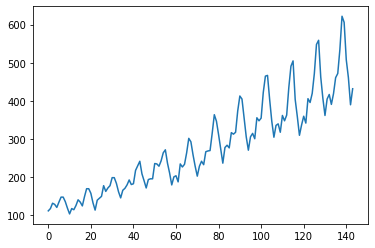

In [68]:
df['#Passengers'].plot()

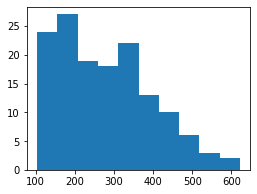

In [69]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.hist(df['#Passengers'].to_numpy())
plt.show()

In [70]:
import statsmodels.tsa.api as tsa

adf_rlt = tsa.adfuller(df['#Passengers'].to_numpy())
print(f'ADF statistics：{adf_rlt[0]}')
print(f'P value：{adf_rlt[1]}')
print(f'{adf_rlt[4]}')

ADF statistics：0.8153688792060472
P value：0.991880243437641
{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [71]:
from sklearn.preprocessing import MinMaxScaler

window_size = 4
train_split = 96

data = df['#Passengers'].to_numpy()
train = data[:train_split]
test = data[train_split:]
sc = MinMaxScaler()
train_mm = sc.fit_transform(train.reshape(-1, 1))
test_mm = sc.transform(test.reshape(-1, 1))

X_train = train_mm
y_train = train_mm
X_test = test_mm
y_test = test_mm

In [72]:
X_train.shape, y_train.shape

((96, 1), (96, 1))

In [73]:
class SimpleDataset(Dataset):
  def __init__(self, x, y, window_size):
    super().__init__()
    self.x = torch.Tensor(x)
    self.y = torch.Tensor(y)
    self.window_size = window_size

  def __len__(self):
    return len(self.x) - self.window_size # data - M
  
  def __getitem__(self, index):
    return self.x[index : index+self.window_size], self.y[index+self.window_size]


BATCH_SIZE = 32
train_dataloader = DataLoader(SimpleDataset(X_train, y_train, window_size), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(SimpleDataset(X_test, y_test, window_size), batch_size=1)
dataloaders_dict = {'train': train_dataloader}

In [75]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
      super(LSTM, self).__init__()
      self.hidden_size = hidden_size
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True) # input*hidden
      self.num_layers = num_layers
      self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
      r, (h_out, _) = self.lstm(x)
      h_out = h_out.view(-1, self.hidden_size) # reshape
      out = self.fc(h_out)
      
      return out

In [76]:
n_epoch = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

model = LSTM(input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [77]:
def train_model(model, criterion, optimizer, num_epochs=10):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    for epoch in range(num_epochs):
        print('-' * 20)
        print('Epoch {}'.format(epoch+1))

        for phase in ['train']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, targets in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

    return model

model = train_model(model, criterion, optimizer, n_epoch)

ストリーミング出力は最後の 5000 行に切り捨てられました。
Epoch 334
train Loss: 0.0050
--------------------
Epoch 335
train Loss: 0.0050
--------------------
Epoch 336
train Loss: 0.0050
--------------------
Epoch 337
train Loss: 0.0050
--------------------
Epoch 338
train Loss: 0.0050
--------------------
Epoch 339
train Loss: 0.0050
--------------------
Epoch 340
train Loss: 0.0050
--------------------
Epoch 341
train Loss: 0.0050
--------------------
Epoch 342
train Loss: 0.0050
--------------------
Epoch 343
train Loss: 0.0050
--------------------
Epoch 344
train Loss: 0.0050
--------------------
Epoch 345
train Loss: 0.0050
--------------------
Epoch 346
train Loss: 0.0050
--------------------
Epoch 347
train Loss: 0.0050
--------------------
Epoch 348
train Loss: 0.0050
--------------------
Epoch 349
train Loss: 0.0050
--------------------
Epoch 350
train Loss: 0.0050
--------------------
Epoch 351
train Loss: 0.0050
--------------------
Epoch 352
train Loss: 0.0050
--------------------
Epoch 353
train Lo

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
rst = []  
for i, (inputs, targets) in enumerate(test_dataloader):
  inputs = inputs.to(device)
  
  with torch.set_grad_enabled(False):
     outputs = model(inputs)
     if i == 0:
       rst.extend(outputs[0].to('cpu').detach().tolist())
     else:
       rst.extend(outputs[:, -1].to('cpu').detach())

rst = np.array(rst)

In [80]:
rst_inv = sc.inverse_transform(rst.reshape(-1, 1))
y_inv = sc.inverse_transform(y_test)

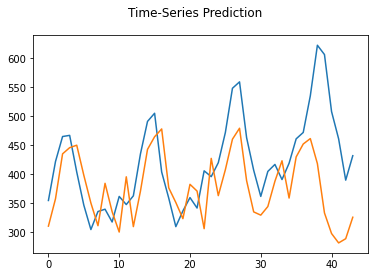

In [81]:
plt.plot(sc.inverse_transform(y_test)[window_size:])
plt.plot(rst_inv)
plt.suptitle('Time-Series Prediction')
plt.show()